In [1]:
def load_and_preprocess_data(debug=False):
    import numpy as np
    from tensorflow.keras.datasets.fashion_mnist import load_data

# Step-1: load the raw dataset
    (X_train, y_train), (X_test, y_test) = load_data()

    if debug:
        print('Before preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))

# Step-2: split the X_test/y_test dataset into cross-val & test datasets

    # per Andrew Ng's advise in his Structured ML coure (on deeplearning.ai), the test 
    # & cross-validation datasets must come from the same distribution!
    # So, we are going to split X_test/y_test into cross-validation & test datasets.
    # We have 10,000 samples in X_test/y_test - we will assign 8,000 to X_val/y_val & the
    # remaining 2,000 to X_test/y_test (test dataset) AFTER randomly sorting the dataset

    # randomly sort X_test/y_test
    indexes = np.arange(X_test.shape[0])
    for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
    X_test = X_test[indexes]
    y_test = y_test[indexes]
    
    # 'split' into cross-val & test sets (use 6000 records in cross-val set)    
    val_count = 8000
    X_val = X_test[:val_count]
    y_val = y_test[:val_count]
    X_test = X_test[val_count:]
    y_test = y_test[val_count:]

    # keep an non pre-processed copy of X_test/y_test for visualization
    test_images, test_labels = X_test.copy(), y_test.copy()
    
# Step-3: scale the images
    # scale the images to between 0-1
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0

# Step-4: reshape the images into 3D tensors so our CNN can consume it
    # reshape the image arrays (make 2D arrays instead of 3D arrays)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

    if debug:
        print('After preprocessing:')
        print(' - X_train.shape = {}, y_train.shape = {}'.format(X_train.shape, y_train.shape))
        print(' - X_val.shape = {}, y_val.shape = {}'.format(X_val.shape, y_val.shape))
        print(' - X_test.shape = {}, y_test.shape = {}'.format(X_test.shape, y_test.shape))
        print(' - test_images.shape = {}, test_labels.shape = {}'.format(test_images.shape,
            test_labels.shape))

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (test_images, test_labels)

In [2]:
def display_sample(sample_images, sample_labels, sample_predictions=None, num_rows=5, num_cols=10,
                   plot_title=None, fig_size=None):
    """ display a random selection of images & corresponding labels, optionally with predictions
        The display is laid out in a grid of num_rows x num_col cells
        If sample_predictions are provided, then each cell's title displays the prediction 
        (if it matches actual) or actual/prediction if there is a mismatch
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    assert sample_images.shape[0] == num_rows * num_cols

    # a dict to help encode/decode the labels
    FASHION_LABELS = {
        0: 'T-shirt/top',
        1: 'Trouser',
        2: 'Pullover',
        3: 'Dress',
        4: 'Coat',
        5: 'Sandal',
        6: 'Shirt',
        7: 'Sneaker',
        8: 'Bag',
        9: 'Ankle boot',
    }

    with sns.axes_style("whitegrid"):
        sns.set_context("notebook", font_scale=1.1)
        sns.set_style({"font.sans-serif": ["Verdana", "Arial", "Calibri", "DejaVu Sans"]})

        f, ax = plt.subplots(num_rows, num_cols, figsize=((14, 9) if fig_size is None else fig_size),
            gridspec_kw={"wspace": 0.02, "hspace": 0.30}, squeeze=True)

        for r in range(num_rows):
            for c in range(num_cols):
                image_index = r * num_cols + c
                ax[r, c].axis("off")
                # show selected image
                ax[r, c].imshow(sample_images[image_index], cmap="Greys")

                if sample_predictions is None:
                    # show the actual labels in the cell title
                    title = ax[r, c].set_title("%s" % FASHION_LABELS[sample_labels[image_index]])
                else:
                    # else check if prediction matches actual value
                    true_label = sample_labels[image_index]
                    pred_label = sample_predictions[image_index]
                    prediction_matches_true = (sample_labels[image_index] == sample_predictions[image_index])
                    if prediction_matches_true:
                        # if actual == prediction, cell title is prediction shown in green font
                        title = FASHION_LABELS[true_label]
                        title_color = 'g'
                    else:
                        # if actual != prediction, cell title is actua/prediction in red font
                        title = '%s/%s' % (FASHION_LABELS[true_label], FASHION_LABELS[pred_label])
                        title_color = 'r'
                    # display cell title
                    title = ax[r, c].set_title(title)
                    plt.setp(title, color=title_color)
        # set plot title, if one specified
        if plot_title is not None:
            f.suptitle(plot_title)

        plt.show()
        plt.close()

In [3]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), \
  (test_images, test_labels) = load_and_preprocess_data()

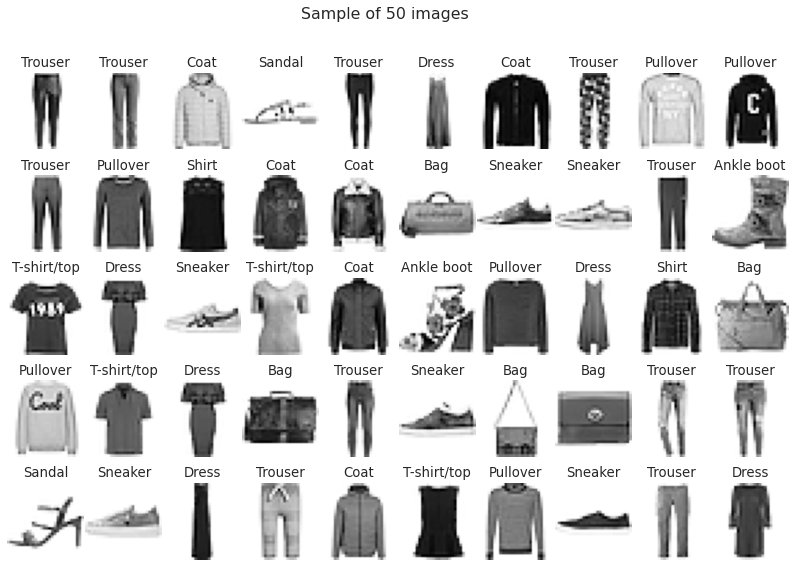

In [4]:
import numpy as np
sample_size = 50
rand_indexes = np.random.randint(0, len(X_test), sample_size)
sample_images = test_images[rand_indexes]
sample_labels = test_labels[rand_indexes]
display_sample(sample_images, sample_labels, 
               plot_title='Sample of %d images' % sample_size)

In [5]:
# Keras imports (from Tensorflow) - we are using Tensorflow's implementation of Keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, 
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# these are my helper functions for Keras
import kr_helper_funcs as kru

IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10

def build_model():
    """
    builds the base Keras model, without any regularization
    """
    K.clear_session()
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        
        Dense(512, activation='relu'),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)       5

In [18]:
# cross-train model & evaluate performance on train & cross-validation data
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test,
                             num_epochs=25, batch_size=32, plot_title=None, 
                             callbacks=None, model_save_name=None):
    """
    cross train & evaluate model's performance on training, cross-val & test datasets
    @params:
        - X_train/y_train: pre-processed training datasets
        - X_val/y_val: pre-processed cross-validation datasets
        - X_test/y_test: pre-processed testing datasets
        - epochs (optional, default=25) - no of epochs for which training should be done
        - batch_size (optional, default=32) - the batch size to use for mini-batch gradient descent training
        - plot_title (optional, default=None) - plots loss vs epochs and accuracy vs epoch curves if assigned value
            other than None. Uses this assigned value as the plot's title
        - model_save_name (optional, default=None) - the file name to which the Keras model is to be saved to.
    """
    
    # train on X_train/y_train & cross-validate on X_val/y_val
    history = model.fit(X_train, y_train, epochs=num_epochs,
        batch_size=batch_size, validation_data=(X_val, y_val), callbacks=callbacks)
    
    print (history)
    kru.show_plots(history.history, plot_title=plot_title)

    # evaluate metrics
    print("\nEvaluating...", flush=True)
    print('Training data:', flush=True)
    loss, acc = model.evaluate(X_train, y_train, verbose=1)
    print("  Training : loss %.3f - acc %.3f" % (loss, acc))
    print('Cross-validation data:', flush=True)
    loss, acc = model.evaluate(X_val, y_val, verbose=1)
    print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
    print('Test data:', flush=True)
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    print("  Testing  : loss %.3f - acc %.3f" % (loss, acc))
    
    if model_save_name is not None:
        print('Saving model...', flush=True)
        kru.save_keras_model(model, model_save_name, model_save_name)

In [ ]:
model = build_model()
print(model.summary())
model_name_base = 'kr_fashion_cnn_base'
plot_title_base = 'Keras Base Model'
train_and_evaluate_model(model, X_train, y_train, 
                         X_val, y_val, X_test, y_test, 
                         num_epochs=4, batch_size=64, 
                         plot_title=plot_title_base, model_save_name=model_name_base) 
del model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)       5